In [1]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
import os

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from dataset.dataset import load_data
from dataset.utils import *
import matplotlib.pyplot as plt

from models.vgg import *

In [2]:
# Joint Model
def ModelXtoCtoY(n_class_attr, pretrained, freeze, num_classes, n_attributes, expand_dim, use_relu, use_sigmoid, train=True, **kwargs):
	vgg_model = vgg16_bn(pretrained=pretrained, num_classes=num_classes, n_attributes=n_attributes, bottleneck=True, expand_dim=expand_dim, train=train, **kwargs)
	model1 = x_to_c_model(freeze=freeze, model=vgg_model)
	if n_class_attr == 3:
		model2 = MLP(input_dim=n_attributes * n_class_attr, num_classes=num_classes, expand_dim=expand_dim, train=train)
	else:
		model2 = MLP(input_dim=n_attributes, num_classes=num_classes, expand_dim=expand_dim, train=train)
	return End2EndModel(model1, model2, use_relu, use_sigmoid, n_class_attr)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Device:", device, torch.cuda.get_device_name(0))
else:
    print("Device:", device)

Device: cuda:0 NVIDIA GeForce GTX 1080 Ti


In [11]:
use_relu = False
use_sigmoid = True
freeze = False
expand_dim = 0
pretrained = False
train = True
n_class_attr = 2

In [12]:
# CBM dataset split and model (112 class level concpts)

N_CONCEPT = 112

test_split = pickle.load(open("./dataset/CUB/dataset_splits/CBM_dataset_split/test.pkl", "rb"))
train_split = pickle.load(open("./dataset/CUB/dataset_splits/CBM_dataset_split/train.pkl", "rb"))
test_loader = load_data("./dataset/CUB/dataset_splits/CBM_dataset_split/test.pkl", 16, image_dir='dataset/CUB/data/images')
train_loader = load_data("./dataset/CUB/dataset_splits/CBM_dataset_split/train.pkl", 16, image_dir='dataset/CUB/data/images')

class_index_to_string = IndexToString("./dataset/CUB/data/classes.txt", classes=True)
concept_index_to_string = IndexToString("./dataset/CUB/dataset_splits/CBM_dataset_split/attributes.txt")

XtoCtoY_model = ModelXtoCtoY(n_class_attr=n_class_attr, pretrained=pretrained, num_classes=200, n_attributes=112, expand_dim=expand_dim, freeze=freeze, use_relu=use_relu, use_sigmoid=use_sigmoid, train=train)
XtoCtoY_model.load_state_dict(torch.load("./saves/CBM_paper/state_dict/independant_seed1.pth"))
XtoCtoY_model.to(device)
XtoCtoY_model.eval()

print("model loaded")

model loaded


In [5]:
# explanable CBM dataset split and model (312 sample level concpts)

N_CONCEPT = 312

test_split = pickle.load(open("./dataset/CUB/explainable_CUB_dataset_split_train_val/val.pkl", "rb"))
train_split = pickle.load(open("./dataset/CUB/explainable_CUB_dataset_split_train_val/train.pkl", "rb"))
test_loader = load_data("./dataset/CUB/explainable_CUB_dataset_split_train_val/val.pkl", 16, image_dir='dataset/CUB/data/images')  # only has val, no test split
train_loader = load_data("./dataset/CUB/explainable_CUB_dataset_split_train_val/train.pkl", 16, image_dir='dataset/CUB/data/images')

class_index_to_string = IndexToString("./dataset/CUB/data/classes.txt", classes=True)
concept_index_to_string = IndexToString("./dataset/CUB/data/attributes.txt")

XtoCtoY_model = ModelXtoCtoY(n_class_attr=n_class_attr, pretrained=pretrained, num_classes=200, n_attributes=312, expand_dim=expand_dim, freeze=freeze, use_relu=use_relu, use_sigmoid=use_sigmoid, train=train)
XtoCtoY_model.load_state_dict(torch.load("./saves/explainable/state_dict/independent2.pth"))
XtoCtoY_model.to(device)
XtoCtoY_model.eval()

print("model loaded")

model loaded


In [13]:
attr_count = []
for i in range(N_CONCEPT):
    attr_count.append(0)

Print a list of the count of occurances for each concept

In [14]:
for sample in test_split:
    for idx, attr in enumerate(sample["attribute_label"]):
        if attr == 1:
            attr_count[idx] = attr_count[idx] + 1

print(attr_count)

[499, 338, 2382, 1408, 1432, 1337, 357, 2361, 1174, 763, 1352, 1564, 477, 2350, 1018, 735, 354, 551, 832, 892, 2479, 852, 3761, 420, 477, 1324, 1496, 299, 1535, 690, 644, 1688, 996, 1062, 1738, 689, 492, 289, 1268, 384, 490, 857, 929, 2133, 715, 286, 620, 1141, 2123, 376, 5596, 1989, 3635, 293, 818, 676, 443, 1943, 482, 887, 880, 2237, 911, 492, 747, 964, 354, 1293, 1070, 496, 313, 471, 862, 716, 2361, 676, 2481, 874, 3677, 1051, 566, 286, 3496, 2871, 705, 405, 2477, 388, 767, 4342, 1105, 1265, 742, 1595, 1171, 536, 1250, 1626, 635, 744, 2860, 316, 293, 847, 676, 323, 1915, 422, 1532, 283, 1164, 1295]


In [15]:
def generateClassMatrix(dataloader, model, device):
    nb_classes = 200
    model.eval()

    confusion_matrix = torch.zeros(nb_classes, nb_classes, dtype=torch.int32)

    with torch.no_grad():
        for i, (images, labels, concepts) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            predictions = model(images)
            _, preds = torch.max(predictions[0], 1)
            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.item(), p.item()] += 1

    return confusion_matrix

In [16]:
IMG_SIZE =  299
training_transform = transforms.Compose([
    transforms.ColorJitter(brightness=32/255, saturation=(0.5, 1.5)),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), #implicitly divides by 255
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [2, 2, 2])
    #transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
    ])

other_transform = transforms.Compose([
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(), #implicitly divides by 255
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [2, 2, 2])
    #transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
    ])

In [17]:
matrix = generateClassMatrix(test_loader, XtoCtoY_model, device)

print("Test accuracy")
print("=============")
print(str(torch.mean(matrix.diag()/matrix.sum(1)).item() * 100) + "%")
print("")
print("Per class accuracy")
print("==================")
for i, acc in enumerate(matrix.diag()/matrix.sum(1)):
    print(class_index_to_string(i) + ":", str(acc.item() * 100) + "%")
print("")
print("Confusion materix")
print("=================")
print(matrix)

Test accuracy
77.59514451026917%

Per class accuracy
Black_footed_Albatross: 73.33333492279053%
Laysan_Albatross: 73.33333492279053%
Sooty_Albatross: 92.85714030265808%
Groove_billed_Ani: 43.33333373069763%
Crested_Auklet: 85.71428656578064%
Least_Auklet: 90.90909361839294%
Parakeet_Auklet: 91.30434989929199%
Rhinoceros_Auklet: 72.22222089767456%
Brewer_Blackbird: 31.034481525421143%
Red_winged_Blackbird: 89.99999761581421%
Rusty_Blackbird: 53.33333611488342%
Yellow_headed_Blackbird: 80.7692289352417%
Bobolink: 96.66666388511658%
Indigo_Bunting: 93.33333373069763%
Lazuli_Bunting: 92.85714030265808%
Painted_Bunting: 92.85714030265808%
Cardinal: 96.29629850387573%
Spotted_Catbird: 93.33333373069763%
Gray_Catbird: 68.96551847457886%
Yellow_breasted_Chat: 79.31034564971924%
Eastern_Towhee: 96.66666388511658%
Chuck_will_Widow: 61.538463830947876%
Brandt_Cormorant: 68.96551847457886%
Red_faced_Cormorant: 50.0%
Pelagic_Cormorant: 56.66666626930237%
Bronzed_Cowbird: 73.33333492279053%
Shiny_Co

In [11]:
def getRMSE(model, dataloader, device):

    def rmse(predictions, targets):
        return np.sqrt(np.mean((predictions-targets)**2))

    nb_classes = 200
    model.eval()
    RMSE = []

    with torch.no_grad():
        for i, (images, labels, concepts) in enumerate(dataloader):
            images = images.to(device)
            predictions = model(images)
            _, preds = torch.max(predictions[0], 1)
            RMSE.append(rmse(preds.cpu().data.numpy(), labels.data.numpy()))

    return (sum(RMSE)/len(RMSE))

print(getRMSE(XtoCtoY_model, test_loader, device))

17.14007563632749


In [12]:
"""
Note: making a matrix does not really work for concepts. All the values in the matrix will always follow the diaganal.
* If the prediction was correct it will add to the diaganal (as we would want)
* If the prediction was incorrect it will add to the diaginal and there is no clear way to add to another column (perhaps not possible??)
* If the preduction was missed then it will add to the diaginal.

A better solutin (for now): Create a number of lists for correct predictions, missed predictions and incorrect predictions
"""
def generateConceptMatrix(dataloader, model, device):
    nb_concepts = N_CONCEPT
    model.eval()

    confusion_matrix = torch.zeros(nb_concepts, nb_concepts, dtype=torch.int32)

    with torch.no_grad():
        for i, (images, labels, concepts) in enumerate(dataloader):
            images, labels, concepts = next(iter(dataloader))
            images, concepts = images.to(device), concepts.to(device)
            predictions = model.first_model(images)
            predictions = torch.nn.Sigmoid()(torch.cat(predictions, dim=1))
            for item_index, pred_vector in enumerate(predictions):
                #print(pred_vector)
                acc_vector = []
                for pred_concept in pred_vector:
                    if pred_concept.item() >= 0.5:
                        acc_vector.append(1)
                    else:
                        acc_vector.append(0)
                #print()
                #print(acc_vector)
                #print(concepts.view(-1), acc_vector)
                #for idx, true_item in enumerate(concepts[item_index].view(-1)):
                #    for idy, pred_item in enumerate(acc_vector):
                #        if int(true_item.item()) == 1 or pred_item == 1:  # only count a predicted concept if it was predicted true or meant to be predicted true
                #            #print(idx, idy)
                #            #print(true_item, pred_item)
                #            confusion_matrix[idx, idy] += 1
                for idx, (t, p) in enumerate(zip(concepts[item_index].view(-1), acc_vector)):
                    if int(t.item()) == 1 or p == 1:
                        confusion_matrix[idx, idx] += 1

    return confusion_matrix

In [13]:
def getConceptPredictionLists(dataloader, model, device):
    nb_concepts = N_CONCEPT
    model.eval()
    
    correct_count = []
    incorrect_count = []
    missed_count = []
    for i in range(nb_concepts):
        correct_count.append(0)
        incorrect_count.append(0)
        missed_count.append(0)

    with torch.no_grad():
        for i, (images, labels, concepts) in enumerate(dataloader):
            #images, labels, concepts = next(iter(dataloader))
            images, concepts = images.to(device), concepts.to(device)
            predictions = model(images)
            _, class_preds = torch.max(predictions[0], 1)
            concept_preds = torch.nn.Sigmoid()(predictions[1])
            for item_index, pred_vector in enumerate(concept_preds):
                #print(pred_vector.size(), item_index)
                #print(pred_vector)
                acc_vector = []
                for pred_concept in pred_vector:
                    if pred_concept.item() >= 0.5:
                        acc_vector.append(1)
                    else:
                        acc_vector.append(0)
                # idx == concept index, t == true concepts from the dataset, p == predicted concepts
                for idx, (t, p) in enumerate(zip(concepts[item_index].view(-1), acc_vector)):
                    if int(t.item()) == 1 and p == 1:
                        correct_count[idx] += 1
                    elif int(t.item()) == 1:
                        missed_count[idx] += 1
                    elif p == 1:
                        incorrect_count[idx] += 1
                    else:
                        "something went wrong! Cannot work out if prediction was correct, incorrect or missed"
                

    return correct_count, missed_count, incorrect_count

In [14]:
correct_count, missed_count, incorrect_count = getConceptPredictionLists(test_loader, XtoCtoY_model, device)
print("done")

done


In [15]:
import pandas as pd

In [16]:
def set_concept_group(row):
    if 'shape' in row.name:
        val = 'shape'
    elif 'color' in row.name:
        val = 'colour'
    elif 'pattern' in row.name:
        val = 'pattern'
    else:
        val = 'size_length'
    return val

In [17]:
#concepts_results = []

#for i in range(len(attr_count)):
#    concepts_results.append([attr_count[i], correct_count[i], incorrect_count[i], missed_count[i]])
    
d = {'concept': [concept_index_to_string(x) for x in range(N_CONCEPT)], 'true_concept_count': attr_count, 'correctly_predicted_concepts': correct_count, 'incorrectly_predicted_concepts': incorrect_count, 'missing_concept_predictions': missed_count}
df = pd.DataFrame(data=d).set_index('concept')
df['accuracy'] = df.apply(lambda row: round(100 * (row.correctly_predicted_concepts / row.true_concept_count), 3), axis=1)
df['concept_group'] = df.apply(set_concept_group, axis=1)

In [18]:
with pd.option_context('expand_frame_repr', False, 'display.max_rows', None):
    #print(df.sort_values(by=['accuracy'], ascending=False))
    print(df.sort_values(by=['concept'], ascending=False))
    
print(f"concept accuracy: {(df['correctly_predicted_concepts'].sum()/df['true_concept_count'].sum()) *100}%")

                                         true_concept_count  correctly_predicted_concepts  incorrectly_predicted_concepts  missing_concept_predictions  accuracy concept_group
concept                                                                                                                                                                       
has_wing_shape::tapered-wings                           360                            96                               9                          264    26.667         shape
has_wing_shape::rounded-wings                          1288                           142                              18                         1146    11.025         shape
has_wing_shape::pointed-wings                           845                            74                              10                          771     8.757         shape
has_wing_shape::long-wings                              300                           164                              22    

<Figure size 432x288 with 0 Axes>

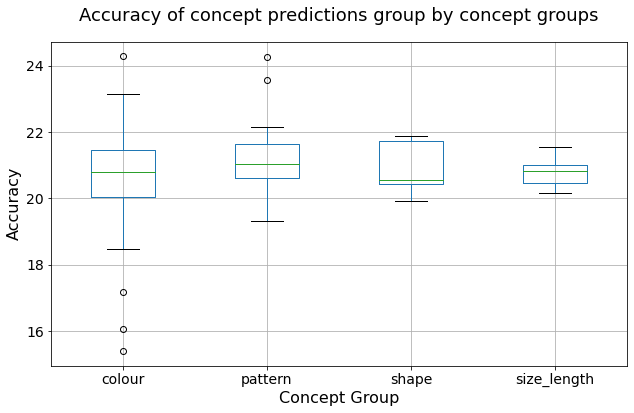

In [22]:
plt.figure()
df.boxplot(by="concept_group", column=['accuracy'], figsize=(10, 6), fontsize=14)
plt.xlabel('Concept Group', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.suptitle('Accuracy of concept predictions group by concept groups', fontsize=18)
plt.title('')
plt.show()

In [46]:
def getConceptPredictionPreClassification(dataloader, model, device):
    nb_concepts = N_CONCEPT
    nb_classes = 200
    model.eval()
    
    """
    each classification has a list with correct, incorrect and missed concepts.
    index of class_list items == classification id
    index of correct_count items, incorrect_count items, missed_count items == concept id
    """
    class_list = []
    for i in range(nb_classes):
        correct_count = []
        incorrect_count = []
        missed_count = []
        for i in range(nb_concepts):
            correct_count.append(0)
            incorrect_count.append(0)
            missed_count.append(0)
        class_list.append([correct_count, incorrect_count, missed_count])

    with torch.no_grad():
        for i, (images, labels, concepts) in enumerate(dataloader):
            #images, labels, concepts = next(iter(dataloader))
            images, concepts = images.to(device), concepts.to(device)
            predictions = model(images)
            _, class_preds = torch.max(predictions[0], 1)
            concept_preds = torch.nn.Sigmoid()(torch.cat(predictions[1:], dim=1))
            for item_index, pred_vector in enumerate(concept_preds):
                #print(pred_vector.size(), item_index)
                #print(pred_vector)
                acc_vector = []
                for pred_concept in pred_vector:
                    if pred_concept.item() >= 0.5:
                        acc_vector.append(1)
                    else:
                        acc_vector.append(0)
                # idx == concept index, t == true concepts from the dataset, p == predicted concepts
                for idx, (t, p) in enumerate(zip(concepts[item_index].view(-1), acc_vector)):
                    if int(t.item()) == 1 and p == 1:
                        class_list[item_index][0][idx] += 1  # correct_count
                    elif int(t.item()) == 1:
                        class_list[item_index][2][idx] += 1  # missed_count
                    elif p == 1:
                        class_list[item_index][1][idx] += 1  # incorrect_count
                    else:
                        "something went wrong! Cannot work out if prediction was correct, incorrect or missed"
                

    return class_list

In [47]:
class_concept_acc_list = getConceptPredictionPreClassification(val_loader, XtoCtoY_model, device)
print("done")

done
